In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math 
from scipy.integrate import odeint
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIRModel as SIR

In [ ]:
# Exercise 1.1
beta = 0.3
gamma = 0.1
mu = 0.05
t = 200

def gillespies_sir(t, S0, I0, R0, beta, gamma, mu):
    times = []
    S_list = []
    I_list = []
    R_list = []
    
    t0 = 0
    S = S0
    I = I0
    R = R0

    while t0 < t and (S + I + R) > 0:
        N = S + I + R
        r_infect = beta * S * I / N
        r_birth = mu * N
        r_recover = gamma * I
        r_deathS = mu * S
        r_deathI = mu * I
        r_deathR = mu * R

        rate0 = r_infect + r_birth + r_recover + r_deathS + r_deathI + r_deathR

        if rate0 <= 0.0:
            break

        u1 = random.uniform(0, 1.0)
        dt = -math.log(u1) / rate0
        t0 += dt
        if t0 > t:
            break

        u2 = random.uniform(0, 1.0) * rate0
        if u2 < r_infect:
            if S > 0:
                S -= 1
                I += 1
        elif u2 < r_infect + r_birth:
            S += 1
        elif u2 < r_infect + r_birth + r_recover:
            if I > 0:
                I -= 1
                R += 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS:
            if S > 0:
                S -= 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS + r_deathI:
            if I > 0:
                I -= 1
        else:
            if R > 0:
                R -= 1   

        times.append(t0)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return times, S_list, I_list, R_list



In [ ]:
# PLotting:
N_vals = [100, 1000, 2000, 5000, 10000]

# Bonus part: controlling noise levels (somewhat?)
# Plot infected fractions for different values of N: more random for smaller N
for N in N_vals:
    S0, I0, R0 = N - 1, 1, 0
    times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
    fracI = np.array(I) / N # normalise since different Ns
    plt.step(times, fracI, where='post', label=f'N={N}')
    
plt.title('Effects of Population Size')
plt.xlabel('Time')
plt.ylabel('Infected Fraction')
plt.legend()
plt.show()

# Choosing N=2000 as reasonable pop size based on the plot
N = 2000
S0, I0, R0 = N - 1, 1, 0
times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
fracS, fracI, fracR = np.array(S) / N, np.array(I) / N, np.array(R) / N #still doing fracrtions for consistency 
plt.step(times, fracS, where='post', label='S')
plt.step(times, fracI, where='post', label='I')
plt.step(times, fracR, where='post', label='R')
plt.title('SIR Dynamics for N=2000')
plt.xlabel('Time')
plt.ylabel('Population Fraction')
plt.legend()
plt.show()


In [ ]:
# Equivalent deterministic ODE:
def det_sir(y, t, beta, gamma, mu):
    S, I, R = y
    N = S + I + R
    dS = mu * N - beta * S * I / N - mu * S
    dI = beta * S * I / N - gamma * I - mu * I
    dR = gamma * I - mu * R
    return dS, dI, dR

def integrate_det_sir(y0, t, beta, gamma, mu):
    results = odeint(det_sir, y0, t, args=(beta, gamma, mu))
    S, I, R = results.T
    return S, I, R

# Plot together to compare:
plt.step(times, S_list, where='post', label='S (stochastic)')
plt.step(times, I_list, where='post', label='I (stochastic)')
plt.step(times, R_list, where='post', label='R (stochastic)')
S_det, I_det, R_det = integrate_det_sir([S0, I0, R0], times, beta, gamma, mu)
plt.plot(times, S_det, 'b--', label='S (deterministic)')
plt.plot(times, I_det, 'r--', label='I (deterministic)')
plt.plot(times, R_det, 'g--', label='R (deterministic)')
plt.title('Stochastic vs Deterministic SIR')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()


In [ ]:
# Exercise 1.2

# Common time grid for comparaisons:
def nice_grid(times, sir, t_grid):
    times = np.array(times)
    vals = np.array(sir)
    index = np.searchsorted(times, t_grid, side='right') - 1 # get value at or before
    index = np.clip(index, 0, len(vals) - 1) 
    return vals[index]

# Get data over multiple runs
def ensemble(n_sims, t, dt, N, beta, gamma, mu):
    t_grid = np.arange(0, t, dt)
    S_ens = np.zeros((n_sims, len(t_grid)))
    I_ens = np.zeros((n_sims, len(t_grid)))
    R_ens = np.zeros((n_sims, len(t_grid)))
    for i in range(n_sims):
        S0, I0, R0 = N - 1, 1, 0
        times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
        S_ens[i, :] = (nice_grid(times, np.array(S) / N, t_grid))
        I_ens[i, :] = (nice_grid(times, np.array(I) / N, t_grid))
        R_ens[i, :] = (nice_grid(times, np.array(R) / N, t_grid))
    return t_grid, S_ens, I_ens, R_ens

# Simulation variabiiity
def get_stats(n_sims, t, dt, N, beta, gamma, mu):
    t_grid, S_ens, I_ens, R_ens = ensemble(n_sims, t, dt, N, beta, gamma, mu)

    S_mean = np.mean(S_ens, axis=0)
    I_mean = np.mean(I_ens, axis=0)
    R_mean = np.mean(R_ens, axis=0)
    # std not pure variance, easier to interpret
    S_std = np.std(S_ens, axis=0)
    I_std = np.std(I_ens, axis=0)
    R_std = np.std(R_ens, axis=0)

    cov = ((S_ens - S_mean) * (I_ens - I_mean)).mean(axis=0)

    # get deterministic sir to compare
    S_det, I_det, R_det = integrate_det_sir([N - 1, 1, 0], t_grid, beta, gamma, mu)
    S_det, I_det, R_det = S_det / N, I_det / N, R_det / N # normalise again

    return {'t': t_grid, 
            'S_mean': S_mean, 'I_mean': I_mean, 'R_mean': R_mean,
            'S_std': S_std, 'I_std': I_std, 'R_std': R_std,
            'cov': cov,
            'S_det': S_det, 'I_det': I_det, 'R_det': R_det}
   
# Plot
def plot_stats(stats, title='STochastic and Deterministic means'):
    t = stats['t']
    I_mean, I_std, I_det = stats['I_mean'], stats['I_std'], stats['I_det']

    plt.figure()
    plt.plot(t, I_mean, color='purple', label='Mean Infected (stochastic)')
    plt.fill_between(t, I_mean - I_std, I_mean + I_std, color='indigo', alpha=0.25, label='±1 Std Dev')
    plt.plot(t, I_det, color='midnightblue', label='Mean Infected (deterministic)')
    plt.xlabel('Time')
    plt.ylabel('Infected Fraction')
    plt.legend()
    plt.title(title)
    plt.show()

def plot_cov(stats, title='Covariance between S and I'):
    t = stats['t']
    cov = stats['cov']
    plt.figure()
    plt.plot(t, cov, color='palevioletred')
    plt.xlabel('Time')
    plt.ylabel('Covariance')
    plt.title(title)
    plt.show()

params = [
    {'type': 'baseline', "N": 2000, "beta": 0.3, "gamma": 0.1, "mu": 0.05},
    {'type': 'small N', "N": 200, "beta": 0.3, "gamma": 0.1, "mu": 0.05},
    {'type': 'high beta', "N": 2000, "beta": 0.5, "gamma": 0.1, "mu": 0.05},
    {'type': 'low beta', "N": 2000, "beta": 0.15, "gamma": 0.1, "mu": 0.05}
]

for p in params:
    stats = get_stats(n_sims=100, t=200, dt=0.1, N=p['N'], beta=p['beta'], gamma=p['gamma'], mu=p['mu'])
    plot_stats(stats, title=f'STochastic and Deterministic means - {p["type"]}')
    plot_cov(stats, title=f'Covariance between S and I - {p["type"]}')

# Part2 - Networks

## 2.1 - up until sociopattern data

#### 'GENERATE NETWORKS OF EQUIVALENT FORM'

In [89]:
# Parameters ('similar characteristics')
N=1000
avg_k = 10

# pretty colors for plots...
colors = {
    'Erdos-Renyi': 'rebeccapurple',
    'Watts-Strogatz': 'darkslategray',
    'Barabasi-Albert': 'hotpink'
}


# Create networks
def make_ws(N, k, seed, p=0.1):
    return nx.watts_strogatz_graph(N, k, p, seed=seed) 

def make_er(N, avg_k, seed):
    p = avg_k / (N - 1)
    return nx.erdos_renyi_graph(N, p, seed=seed)

def make_ba(N, avg_k, seed):
    m = avg_k // 2  
    return nx.barabasi_albert_graph(N, m, seed=seed)



## METRICS AND STATS:

# basic measures:
def get_measures(G, name):
    k = np.array([d for _, d in G.degree()])
    cc = np.fromiter(nx.clustering(G).values(), dtype=float)
    stats= {
        'name': name,
        'nodes' : G.number_of_nodes(),
        'edges' : G.number_of_edges(),
        'avg_degree' : k.mean(),
        'avg_shortest_path': nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf'),
        'avg_clustering_coeff' : nx.average_clustering(G),
    }
    return stats, k, cc
        

# deg dist
def plot_dd(k_data):
    # PDF hist
    plt.figure()
    for name, k in k_data.items():
        plt.hist(k, bins=range(0, max(k)+2), density=True, label=name, alpha=0.5, color=colors[name]) 
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.title('Degree Distribution (PDF)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # CCDF plot
    plt.figure()
    for name, k in k_data.items():
        sorted_k = np.sort(k)
        ccdf = 1 - np.arange(1, len(sorted_k) + 1) / len(sorted_k)
        plt.loglog(sorted_k, ccdf, marker='.', linestyle='none', label=name, alpha=0.5, color=colors[name])
    plt.xlabel('Degree')
    plt.ylabel('CCDF')
    plt.title('Degree Distribution (CCDF)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# clustering dist
def plot_cc(cc_data):
    plt.figure()
    for name, cc in cc_data.items():
        plt.hist(cc, bins=30, density=True, alpha=0.5, label=name, color=colors[name])
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('P(c)')
    plt.title('Clustering Coefficient Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

# centralities:
def get_centralities(G):
    deg_cent = np.fromiter(nx.degree_centrality(G).values(), dtype=float)
    btw_cent = np.fromiter(nx.betweenness_centrality(G, normalized=True).values(), dtype=float)
    clos_cent = np.fromiter(nx.closeness_centrality(G).values(), dtype=float)
    try:
        ev_cent = np.fromiter(nx.eigenvector_centrality_numpy(G).values(), dtype=float)
    except nx.AmbiguousSolution:
        ev_cent = np.full(G.number_of_nodes(), np.nan)
    return deg_cent, btw_cent, clos_cent, ev_cent


def plot_centralities(cent_data):
    cent_names = {
        'deg': 'Degree Centrality',
        'btw': 'Betweenness Centrality',
        'clos': 'Closeness Centrality',
        'eig': 'Eigenvector Centrality'
    }

    for key, label in cent_names.items():
        plt.figure()
        for name, cents in cent_data.items():
            cent = np.array(cents[key])
            cent = cent[~np.isnan(cent)]  
            plt.hist(cent, bins=50, density=True, alpha=0.5, label=name, color=colors[name])
        plt.xlabel(label)
        plt.ylabel('P(c)')
        plt.title(f'{label} Distribution')
        plt.legend()
        plt.grid(True)
        plt.show()




Network measures (averaged):


,nodes,edges,avg_degree,avg_shortest_path,avg_clustering_coeff
0,1000.0,4997.23,9.99446,inf,0.009938
1,1000.0,5000.00,10.00000,4.441046,0.491534
2,1000.0,4975.00,9.95000,2.983357,0.039742


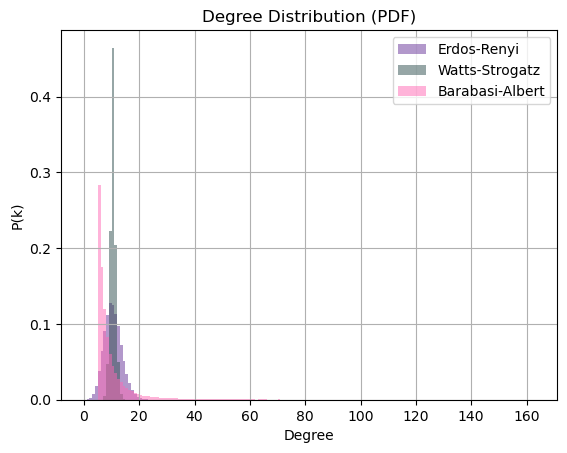

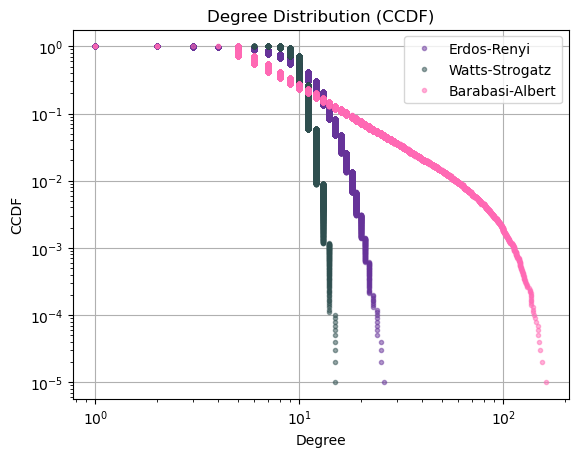

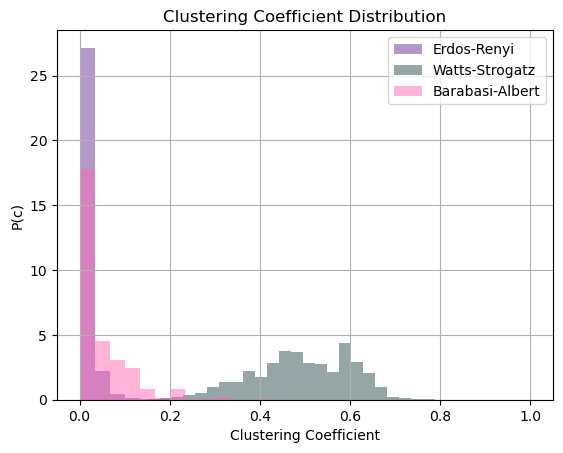

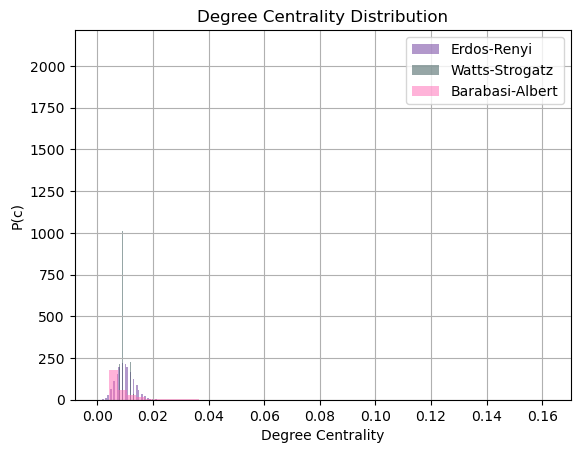

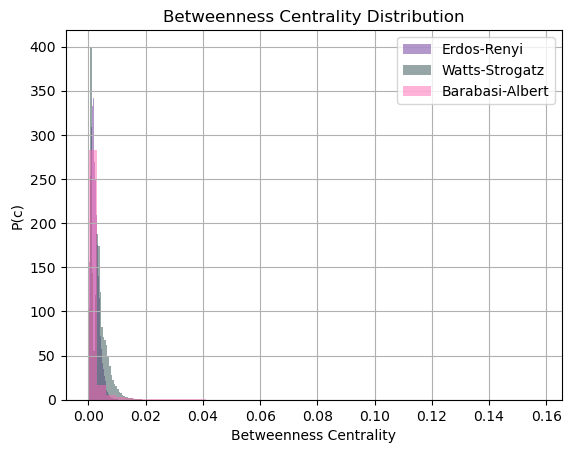

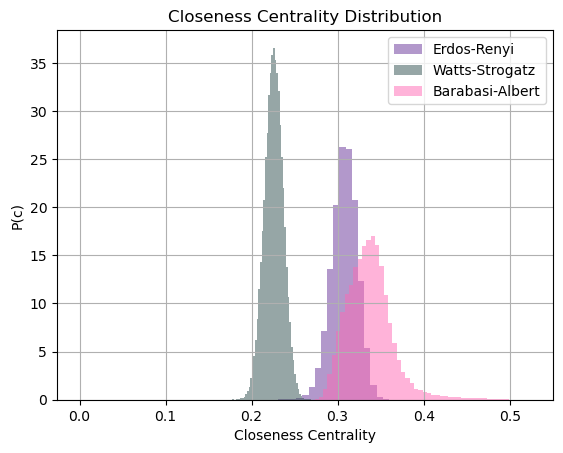

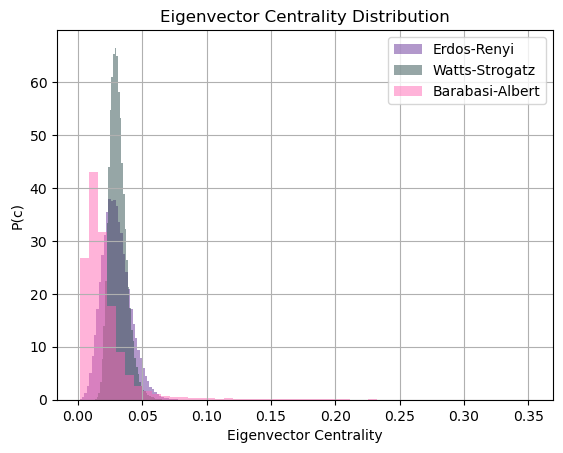

In [91]:
## Basic comparaisons:
networks = {
    'Erdos-Renyi': make_er,
    'Watts-Strogatz': make_ws,
    'Barabasi-Albert': make_ba
}
sums = []
k_data = {}
cc_data = {}
cent_data = {}
seedy = range(1, 101)

for name, make_func in networks.items():
    all_stats = []
    all_k = []
    all_cc = []
    all_cents = {'deg': [], 'btw': [], 'clos': [], 'eig': []}

    for s in seedy:
        if name == 'Watts-Strogatz':
            G = make_func(N, avg_k, s, p=0.1)
        else:
            G = make_func(N, avg_k, s)

        s_stats, k, cc = get_measures(G, name)
        all_stats.append(s_stats)
        all_k.extend(k)
        all_cc.extend(cc)

        deg_cent, btw_cent, clos_cent, ev_cent = get_centralities(G)
        all_cents['deg'].extend(deg_cent)
        all_cents['btw'].extend(btw_cent)
        all_cents['clos'].extend(clos_cent)
        all_cents['eig'].extend(ev_cent)

    # average 
    stats_df = pd.DataFrame(all_stats)
    mean_stats = stats_df.mean(numeric_only=True)
    std_stats = stats_df.std(numeric_only=True)

    # for plots
    sums.append(mean_stats)
    k_data[name] = np.array(all_k)
    cc_data[name] = np.array(all_cc)
    cent_data[name] = all_cents

measures_df = pd.DataFrame(sums)
print("\nNetwork measures (averaged):")
display(measures_df)

plot_dd(k_data)
plot_cc(cc_data)
plot_centralities(cent_data)

In [ ]:
## Varying params:
# not comparing all measures this time, just specific ones for diff topologies
seed = range(42, 143)

def get_specifics(G):
    k = np.array([d for _, d in G.degree()])
    return {
        'avg_degree': k.mean(),
        'degree_var': k.var(),
        'C': nx.average_clustering(G),
        'L': nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf')
    }

def vary_ws(N, k, p_values, seeds):
    data = []
    for p in p_values:
        for s in seeds:
            G = make_ws(N, k, s, p)
            m = get_specifics(G)
            m.update({'p': p, 'seed': s})
            data.append(m)
    return pd.DataFrame(data)

def vary_er(N, k_values, seeds):
    data = []
    for k in k_values:
        for s in seeds:
            G = make_er(N, k, s)
            m = get_specifics(G)
            m.update({'avg_k': k, 'seed': s})
            data.append(m)
    return pd.DataFrame(data)

def vary_ba(N, m_values, seeds):
    data = []
    for m in m_values:
        for s in seeds:
            G = nx.barabasi_albert_graph(N, m, seed=s)
            mtr = get_specifics(G)
            mtr.update({'m': m, 'seed': s})
            data.append(mtr)
    return pd.DataFrame(data)

ws_df = vary_ws(N, avg_k, [0.01, 0.1, 0.5], seed)
er_df = vary_er(N, [ 10, 20, 40], seed)
ba_df = vary_ba(N, [2, 5, 10], seed)

# Plot mean +std
def plot_ens(df, xcol, ycol, label, color):
    grouped = df.groupby(xcol)[ycol]
    x = grouped.mean().index
    x = np.sort(x)
    y_mean = grouped.mean().values
    y_std = grouped.std().values
    plt.plot(x, y_mean, 'o-', color=color, label=label)
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=0.2)

plt.figure()
plot_ens(ws_df, 'p', 'C', 'WS Clustering', 'darkslategray')
plot_ens(ws_df, 'p', 'L', 'WS Path Length', 'hotpink')
plt.xscale('log')
plt.xlabel('Rewiring probability (p)')
plt.ylabel('Measure value')
plt.title('WS networks: mean ± std across 100 runs')
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plot_ens(er_df, 'avg_k', 'C', 'ER Clustering', 'darkslategray')
plot_ens(er_df, 'avg_k', 'L', 'ER Path Length', 'hotpink')
plt.xlabel('Average degree ⟨k⟩')
plt.ylabel('Measure value')
plt.title('ER networks: mean ± std across 100 runs')
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plot_ens(ba_df, 'm', 'degree_var', 'BA degree variance', 'rebeccapurple')
plot_ens(ba_df, 'm', 'C', 'BA clustering', 'darkslategray')
plt.xlabel('m (new links per node)')
plt.ylabel('Measure value')
plt.title('BA networks: mean ± std across 100 runs')
plt.legend(); plt.grid(True); plt.show()

### Implement and simulate part


In [ ]:
# implementations and stats

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)


def initial_nodes(G, k, strategy='rand'):
    if strategy == 'rand':
        return np.random.choice(G.nodes(), k, replace=False).tolist()
    elif strategy == 'high_deg':
        degree_dict = dict(G.degree())
        sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)
        return sorted_nodes[:k]
    elif strategy == 'eigen':
        ev_centrality = nx.eigenvector_centrality_numpy(G)
        sorted_nodes = sorted(ev_centrality, key=ev_centrality.get, reverse=True)
        return sorted_nodes[:k]
    elif strategy == 'cluster':
        node = np.random.choice(G.nodes())
        neighbors = list(G.neighbors(node))
        choice = [node] + neighbors[:max(0, k - 1)]
        if len(choice) < k:
            oth = list(set(G.nodes()) - set(choice))
            choice += list(np.random.choice(oth, k - len(choice), replace=False))
        return choice
    else:
        raise ValueError("??")

    


# Run and get results:
def run_single_sir(G, beta, gamma, infected_nodes, max_iter, seed):
    set_all_seeds(seed) # keeping same

    # build
    model = SIR(G)
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(config)

    # get reults
    iters = model.iteration_bunch(max_iter)
    node_counts = [i.get('node_count', {0: 0, 1: 0, 2: 0}) for i in iters]
    node_count = np.array([[d.get(0, 0), d.get(1, 0), d.get(2, 0)] for d in node_counts])

    N = G.number_of_nodes()
    t = np.arange(len(node_count))
    S, I, R = node_count[:, 0] / N, node_count[:, 1] / N, node_count[:, 2] / N

    series = pd.DataFrame({'t': t, 'S': S, 'I': I, 'R': R})
    return iters, series


# Ensemble and stats:

# helper
def stats_series(df):
    return{
    'peak_I': df['I'].max(),
    'time_to_peak': df.loc[df['I'].idxmax(), 't'],
    'final_frac_R': df['R'].iloc[-1]
    }

# Run ensemble
def ensemble_nx(n_sims, G, beta, gamma, k, strategy, max_iter, seed):
    series = []
    stats_a =[]
    for i in range(n_sims):
        init_n = initial_nodes(G, k, strategy=strategy)
    
        _, s = run_single_sir(G, beta, gamma, init_n, max_iter, seed+i)
        series.append(s)
        stats_a.append(stats_series(s))
    
    # matrices
    t = series[0]['t'].values
    S_ens = np.vstack([s['S'].values for s in series])
    I_ens = np.vstack([s['I'].values for s in series])
    R_ens = np.vstack([s['R'].values for s in series])

    stats = dict(
        t=t,
        S_mean=S_ens.mean(0), S_std=S_ens.std(0),
        I_mean=I_ens.mean(0), I_std=I_ens.std(0),
        R_mean=R_ens.mean(0), R_std=R_ens.std(0)
    )

    return series, stats, pd.DataFrame(stats_a)


def plot_I_stats(stats, title='Infected Fraction over Time'):
    t = stats['t']
    I_mean = stats['I_mean']
    I_std = stats['I_std']

    plt.figure()
    plt.plot(t, I_mean, color='hotpink', label='Mean Infected')
    plt.fill_between(t, I_mean - I_std, I_mean + I_std, color='rebeccapurple', alpha=0.25, label='std')
    plt.xlabel('Time')
    plt.ylabel('Infected Fraction')
    plt.legend()
    plt.title(title)
    plt.show()


In [ ]:
# params

betas = [0.02, 0.04, 0.06]
gammas = [0.02, 0.05]
max_iter = 200
n_runs = 100
strats = ['rand', 'high_deg', 'eigen', 'cluster']
ks = [1, 5, 10]
base = 42


networks = {
    'ER': make_er(N=1000, avg_k=10, seed=1),
    'WS': make_ws(N=1000, k=10, seed=1, p=0.1),
    'BA': make_ba(N=1000, avg_k=10, seed=1)
}

results = []
for name, G in networks.items():
    for beta in betas:
        for gamma in gammas:
            for strat in strats:
                for k in ks:
                    series, stats, summary = ensemble_nx(
                        n_sims=n_runs,
                        G=G,
                        beta=beta,
                        gamma=gamma,
                        k=k,
                        strategy=strat,
                        max_iter=max_iter,
                        seed=base 
                    )
                    
                    results.append({
                        'network': name,
                        'beta': beta,
                        'gamma': gamma,
                        'strategy': strat,
                        'init_k': k,
                        'peak_I_mean': summary['peak_I'].mean(),
                        't_peak_mean': summary['time_to_peak'].mean(),
                        'final_R_mean': summary['final_frac_R'].mean()
                    })
                    
                    plot_I_stats(
                        stats,
                        title=f"{name} Network, β={beta}, γ={gamma}, init_strategy={strat}, k={k}"
                    )

# combine
results_df = pd.DataFrame(results)
display(results_df)


In [ ]:
# read in the data
df = pd.read_csv("transmission_network.csv", sep=";")
A = df.drop(columns=["Unnamed: 0"]).to_numpy(dtype=float)
A[A > 0] = 1 # hope i converted correctly??
G = nx.from_numpy_array(A)
print(G)
